Phase 1: Total Windows = 266, Significant = 0
Phase 2: Total Windows = 5679, Significant = 795
Phase 3: Total Windows = 687, Significant = 123
  Segment 1: Total Windows = 936, Significant = 39
  Segment 2: Total Windows = 936, Significant = 180
  Segment 3: Total Windows = 936, Significant = 22
  Segment 4: Total Windows = 936, Significant = 194
  Segment 5: Total Windows = 939, Significant = 123


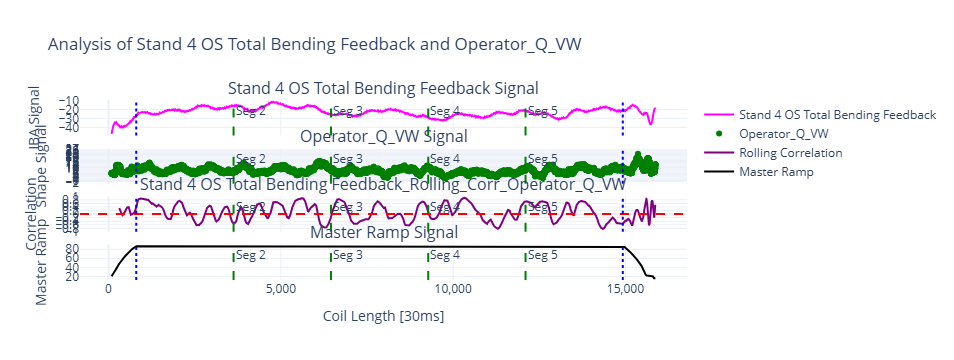

In [5]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def analyze_and_plot_phases(
    df, continuous_col, discrete_col, corr_col,
    coil_length_col, ramp_col="Master Ramp", correlation_threshold=0.7
):
    coil_length_values = df[coil_length_col]

    # if ramp singnal is always low like below 15 then it indicates an invalid or uninteresting run
    if df[ramp_col].max() <= 15:
        print("Low Master Ramp")
        return

    #identified the most common value of the ramp (plateu region or stable region)
    norm_val = df[ramp_col].mode()[0]
    # it contains the only rows where ramp value equals that mode value
    norm_df = df[df[ramp_col] == norm_val]

    # it is the start and end index of the plateu
    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    # phase1_df -> before plateu
    # phase2_df -> plateu itself
    # phase3_df -> after plateu
    phase1_df = df.iloc[:phase1_end + 1]
    phase2_df = df.iloc[phase1_end:phase2_end + 1]
    phase3_df = df.iloc[phase2_end + 1:]

    window_size = 250

    def get_correlation_stats(data):
        # Extracts the correlation values from corr_col, skipping the first window_size - 1 rows and removing any NaN values.
        corr_series = data[corr_col].iloc[window_size - 1:].dropna()
        
        # counts the total number of valid correlation values
        total = len(corr_series)
        
        # Counts how many correlation values have an absolute value ≥ correlation_threshold (default: 0.7).
        significant = (corr_series.abs() >= correlation_threshold).sum()

        # return the tuple of total and significant
        return total, significant

    
    # --- Phase-wise Stats ---
    # Calculates correlation statistics for each phase using the get_correlation_stats function.
    phase1_total, phase1_significant = get_correlation_stats(phase1_df)
    phase2_total, phase2_significant = get_correlation_stats(phase2_df)
    phase3_total, phase3_significant = get_correlation_stats(phase3_df)

    # Outputs the total and significant correlation windows for each phase to the console.
    print(f"Phase 1: Total Windows = {phase1_total}, Significant = {phase1_significant}")
    print(f"Phase 2: Total Windows = {phase2_total}, Significant = {phase2_significant}")
    print(f"Phase 3: Total Windows = {phase3_total}, Significant = {phase3_significant}")

    
    # --- Phase 2 Segmentation (into 5 parts) ---
    seg_size = len(phase2_df) // 5
    phase2_segments = []
    segment_stats = []
    segment_indices = []

    for i in range(5):
        start = i * seg_size
        end = (i + 1) * seg_size if i < 4 else len(phase2_df)
        # print(end, len(phase2_df))
        segment = phase2_df.iloc[start:end]
        phase2_segments.append(segment)

        total, significant = get_correlation_stats(segment)
        segment_stats.append((total, significant))
        global_index = phase2_df.index[start] #we are not using "start" because The start value (e.g., 0, 200, 400) is an index in phase2_df, 
        #which is a subset of df. If phase2_df starts at index 500 in df (because phase1_end = 500), then start = 0 in phase2_df corresponds to index 500 in df
        
        # print(global_index)
        segment_indices.append(global_index)

        print(f"  Segment {i+1}: Total Windows = {total}, Significant = {significant}")

    # --- Plotting ---
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.07,
        subplot_titles=[
            f"{continuous_col} Signal",
            f"{discrete_col} Signal",
            f"{corr_col}",
            f"{ramp_col} Signal"
        ]
    )

    # Signals
    # Row 1: Plots the continuous_col signal as a magenta line.
    # Row 2: Plots the discrete_co1 signal as green markers (discrete points).
    # Row 3: Plots the corr_col (correlation) as a purple line.
    # Row 4: Plots the ramp_col (Master Ramp) as a black line.
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[continuous_col], mode="lines", name=continuous_col,
                             line=dict(color="magenta")), row=1, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[discrete_col], mode="markers", name=discrete_col,
                             marker=dict(color="green", size=6)), row=2, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[corr_col], mode="lines", name="Rolling Correlation",
                             line=dict(color="purple")), row=3, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[ramp_col], mode="lines", name=ramp_col,
                             line=dict(color="black")), row=4, col=1)

    # Zero correlation line
    # It serves as a visual reference to easily distinguish positive correlations (above the line), negative correlations (below the line), and no correlation (at the line),
    fig.add_hline(y=0, line=dict(color="red", dash="dash"), row=3, col=1)

    
    # Vertical lines for Phase boundaries
    x1 = df[coil_length_col].iloc[phase1_end]
    x2 = df[coil_length_col].iloc[phase2_end]
    for row in [1, 2, 3, 4]:
        fig.add_vline(x=x1, line=dict(color="blue", dash="dot"), row=row, col=1)
        fig.add_vline(x=x2, line=dict(color="blue", dash="dot"), row=row, col=1)

    # Vertical lines for segment boundaries
    for i, seg_idx in enumerate(segment_indices[1:], start=2):  # skip the first since it's phase1_end 
        x = df[coil_length_col].iloc[seg_idx]
        for row in [1, 2, 3, 4]:
            fig.add_vline(x=x, line=dict(color="green", dash="dash"),
                          row=row, col=1,
                          annotation_text=f"Seg {i}", annotation_position="top right")
            
        # For the first element in segment_indices[1:] (e.g., 700), i = 2, seg_idx = 700.
        # For the second element (e.g., 900), i = 3, seg_idx = 900.
        # For the third element (e.g., 1100), i = 4, seg_idx = 1100.
        # For the fourth element (e.g., 1300), i = 5, seg_idx = 1300.

    fig.update_yaxes(title_text="IBA Signal", row=1, col=1)
    fig.update_yaxes(title_text="Shape Signal", dtick=1, row=2, col=1)
    fig.update_yaxes(title_text="Correlation", range=[-1, 1], dtick=0.2, row=3, col=1)
    fig.update_yaxes(title_text="Master Ramp", row=4, col=1)

    fig.update_xaxes(tickformat=",.0f", row=4, col=1)
    fig.update_layout(
        title_text=f"Analysis of {continuous_col} and {discrete_col}",
        height=1000,
        xaxis4=dict(title=coil_length_col),
        template="plotly_white",
        showlegend=True
    )

    fig.show()
# Example usage
df = pd.read_csv("5418920.csv")
analyze_and_plot_phases(
    df,
    continuous_col="Stand 4 OS Total Bending Feedback",
    discrete_col="Operator_Q_VW",
    corr_col="Stand 4 OS Total Bending Feedback_Rolling_Corr_Operator_Q_VW",
    coil_length_col="Coil Length [30ms]",
    ramp_col="Master Ramp"
)


--- Coil ID: 5456986 ---
Phase 1: Total Windows = 269, Significant = 0
Phase 2: Total Windows = 5458, Significant = 0
Phase 3: Total Windows = 697, Significant = 0
  Segment 1: Total Windows = 1091, Significant = 0
  Segment 2: Total Windows = 1091, Significant = 0
  Segment 3: Total Windows = 1091, Significant = 0
  Segment 4: Total Windows = 1091, Significant = 0
  Segment 5: Total Windows = 1094, Significant = 0


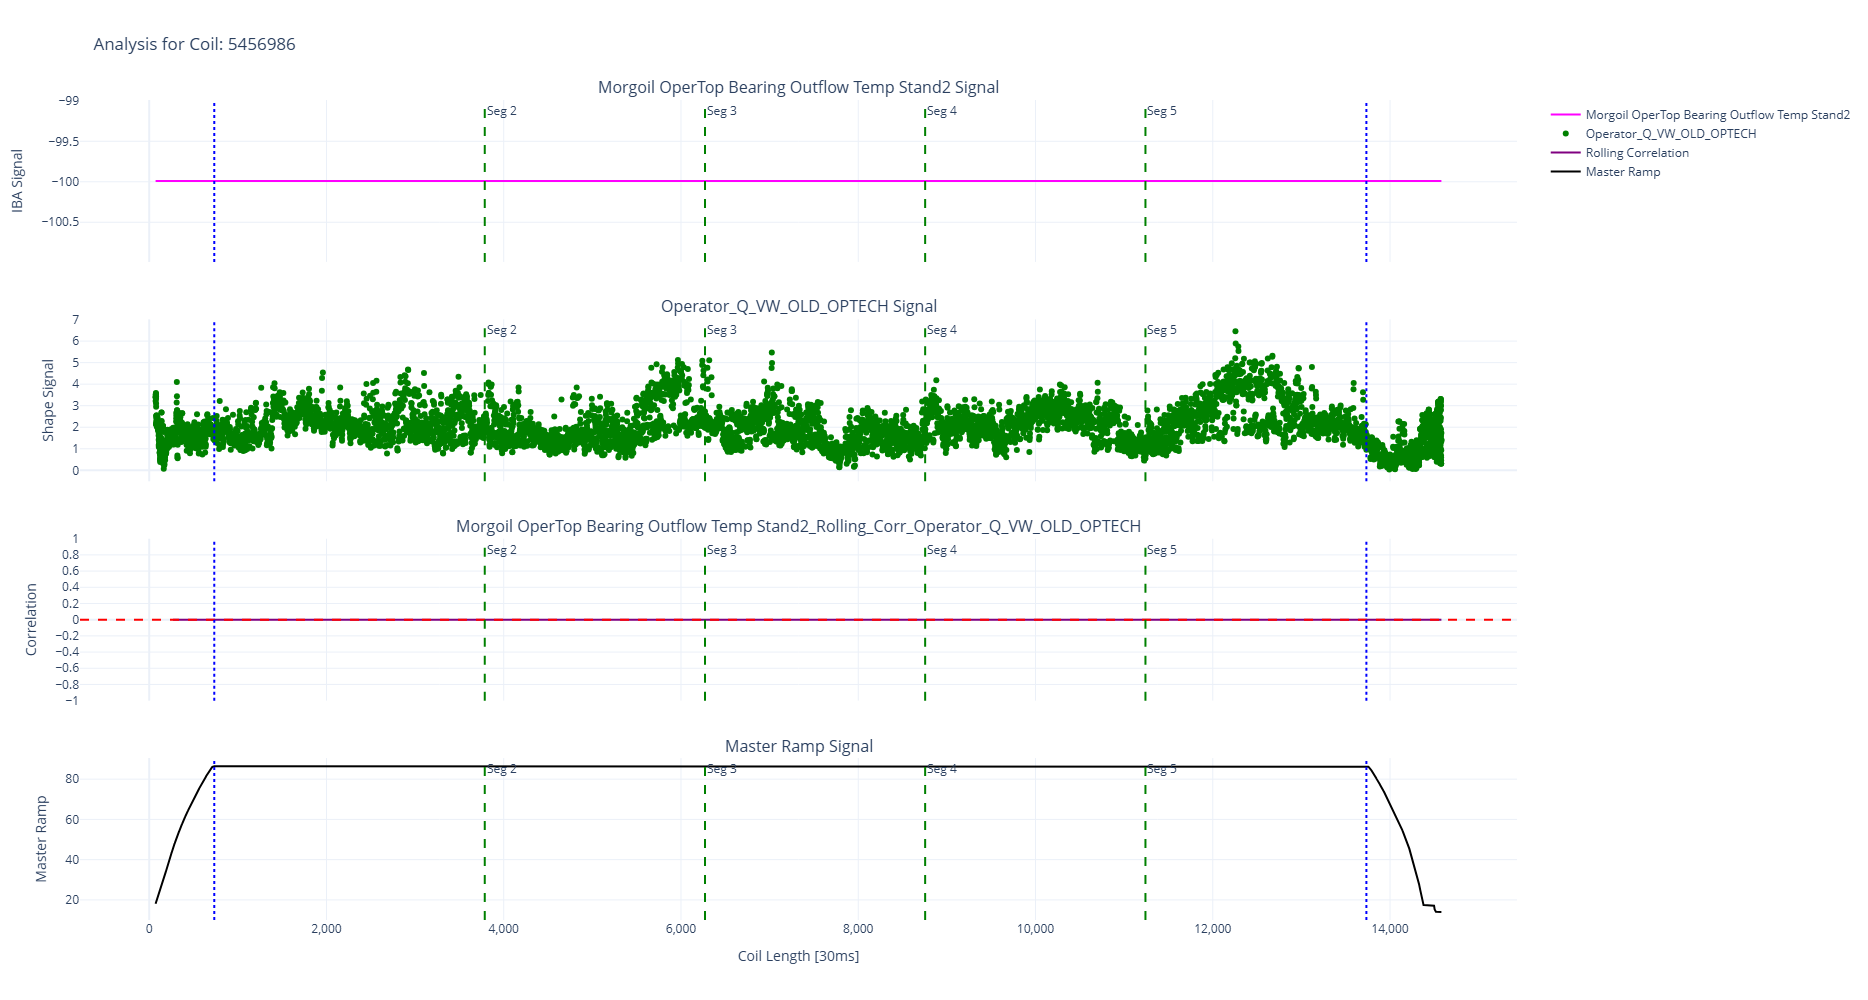

In [13]:
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

results = []  # To collect data for CSV

def analyze_and_plot_phases(
    df, coil_id, continuous_col, discrete_col, corr_col,
    coil_length_col, ramp_col="Master Ramp", correlation_threshold=0.7,
    #coil_type=None, grade=None
):
    coil_length_values = df[coil_length_col]
    window_size = 250

    if df[ramp_col].max() <= 15:
        print(f"[{coil_id}] Low Master Ramp")
        return

    # Determine phase boundaries using mode of ramp signal
    norm_val = df[ramp_col].mode()[0]
    norm_df = df[df[ramp_col] == norm_val]
    phase1_end = norm_df.index[0]
    phase2_end = norm_df.index[-1]

    phase1_df = df.iloc[:phase1_end + 1]
    phase2_df = df.iloc[phase1_end:phase2_end + 1]
    phase3_df = df.iloc[phase2_end + 1:]

    def get_correlation_stats(data):
        corr_series = data[corr_col].iloc[window_size:].dropna()
        total = len(corr_series)
        significant = (corr_series.abs() >= correlation_threshold).sum()
        return total, significant

    # Phase-wise stats
    print(f"\n--- Coil ID: {coil_id} ---")
    phase1_total, phase1_significant = get_correlation_stats(phase1_df)
    phase2_total, phase2_significant = get_correlation_stats(phase2_df)
    phase3_total, phase3_significant = get_correlation_stats(phase3_df)

    print(f"Phase 1: Total Windows = {phase1_total}, Significant = {phase1_significant}")
    print(f"Phase 2: Total Windows = {phase2_total}, Significant = {phase2_significant}")
    print(f"Phase 3: Total Windows = {phase3_total}, Significant = {phase3_significant}")

    # Store phase-wise
    results.extend([
        {
            "Coil ID": coil_id,
            "Phase": "Phase 1", "Segment": "-",
            "Total Windows": phase1_total,
            "Significant Windows": phase1_significant,
            "Contribution %": round((phase1_significant / phase1_total) * 100, 2) if phase1_total else 0
        },
        {
            "Coil ID": coil_id,
            "Phase": "Phase 2", "Segment": "-",
            "Total Windows": phase2_total,
            "Significant Windows": phase2_significant,
            "Contribution %": round((phase2_significant / phase2_total) * 100, 2) if phase2_total else 0
        },
        {
            "Coil ID": coil_id,
            "Phase": "Phase 3", "Segment": "-",
            "Total Windows": phase3_total,
            "Significant Windows": phase3_significant,
            "Contribution %": round((phase3_significant / phase3_total) * 100, 2) if phase3_total else 0
        }
    ])

    # Segment Phase 2
    phase2_corr_series = df.loc[phase2_df.index, corr_col].iloc[window_size:].dropna()
    valid_phase2_indices = phase2_corr_series.index
    valid_phase2_df = df.loc[valid_phase2_indices]

    seg_size = len(valid_phase2_df) // 5
    segment_indices = []

    segment_totals = 0
    segment_significants = 0

    for i in range(5):
        start = i * seg_size
        end = (i + 1) * seg_size if i < 4 else len(valid_phase2_df)
        segment = valid_phase2_df.iloc[start:end]
        segment_corr = phase2_corr_series[segment.index]

        total = len(segment_corr)
        significant = (segment_corr.abs() >= correlation_threshold).sum()

        segment_totals += total
        segment_significants += significant

        print(f"  Segment {i+1}: Total Windows = {total}, Significant = {significant}")

        results.append({
            "Coil ID": coil_id,
            "Phase": "Phase 2", "Segment": f"Segment {i+1}",
            "Total Windows": total,
            "Significant Windows": significant,
            "Contribution %": round((significant / total) * 100, 2) if total else 0
        })

        segment_indices.append(segment.index[0])

    assert segment_totals == phase2_total, "Segment total windows do not match Phase 2"
    assert segment_significants == phase2_significant, "Segment significant counts do not match Phase 2"
            
    # Plotting
    fig = make_subplots(
        rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.07,
        subplot_titles=[
            f"{continuous_col} Signal",
            f"{discrete_col} Signal",
            f"{corr_col}",
            f"{ramp_col} Signal"
        ]
    )

    fig.add_trace(go.Scatter(x=coil_length_values, y=df[continuous_col], mode="lines", name=continuous_col,
                             line=dict(color="magenta")), row=1, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[discrete_col], mode="markers", name=discrete_col,
                             marker=dict(color="green", size=6)), row=2, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[corr_col], mode="lines", name="Rolling Correlation",
                             line=dict(color="purple")), row=3, col=1)
    fig.add_trace(go.Scatter(x=coil_length_values, y=df[ramp_col], mode="lines", name=ramp_col,
                             line=dict(color="black")), row=4, col=1)

    fig.add_hline(y=0, line=dict(color="red", dash="dash"), row=3, col=1)

    x1 = df[coil_length_col].iloc[phase1_end]
    x2 = df[coil_length_col].iloc[phase2_end]
    for row in [1, 2, 3, 4]:
        fig.add_vline(x=x1, line=dict(color="blue", dash="dot"), row=row, col=1)
        fig.add_vline(x=x2, line=dict(color="blue", dash="dot"), row=row, col=1)

    for i, seg_idx in enumerate(segment_indices[1:], start=2):
        x = df[coil_length_col].loc[seg_idx]
        for row in [1, 2, 3, 4]:
            fig.add_vline(x=x, line=dict(color="green", dash="dash"),
                          row=row, col=1,
                          annotation_text=f"Seg {i}", annotation_position="top right")

    fig.update_yaxes(title_text="IBA Signal", row=1, col=1)
    fig.update_yaxes(title_text="Shape Signal", dtick=1, row=2, col=1)
    fig.update_yaxes(title_text="Correlation", range=[-1, 1], dtick=0.2, row=3, col=1)
    fig.update_yaxes(title_text="Master Ramp", row=4, col=1)

    fig.update_xaxes(tickformat=",.0f", row=4, col=1)
    fig.update_layout(
        title_text=f"Analysis for Coil: {coil_id}",
        height=1000,
        xaxis4=dict(title=coil_length_col),
        template="plotly_white",
        showlegend=True
    )

    fig.show()


# ----------------------
# Load Metadata and Process All Coils
# ----------------------

import os
import pandas as pd

# Load the CSV with the "Coil ID" column
metadata_df = pd.read_csv("Histogram Data.csv")

for _, row in metadata_df.iterrows():
    coil_id = str(row["Coil ID"]).split('.')[0]
    if(int(coil_id) == 5456986):
        # Paths now use the new folder and naming convention
        csv_path = os.path.join(r"D:\Stelco\Work\Dynamic Correlation\Key\Master whole Phase", f"{coil_id}.csv")
        if not os.path.exists(csv_path):
            print(f"File not found: {csv_path}")
            continue
    
        try:
            df = pd.read_csv(csv_path)
            # Call the function, adjust arguments as needed. Only coil_id is guaranteed; others may not be in the row anymore.
            analyze_and_plot_phases(
                df,
                coil_id=coil_id,
                # continuous_col="Exit Tension Reel Tension Reference",
                # discrete_col="Driver_Q_VW_OLD_OPTECH",
                # corr_col="Exit Tension Reel Tension Reference_Rolling_Corr_Driver_Q_VW_OLD_OPTECH",
                # coil_length_col="Coil Length [30ms]",
                # ramp_col="Master Ramp"
                continuous_col="Morgoil OperTop Bearing Outflow Temp Stand2",
                discrete_col="Operator_Q_VW_OLD_OPTECH",
                corr_col="Morgoil OperTop Bearing Outflow Temp Stand2_Rolling_Corr_Operator_Q_VW_OLD_OPTECH",
                coil_length_col="Coil Length [30ms]",
                ramp_col="Master Ramp"
            )
        except Exception as e:
            print(f"Error processing {coil_id}: {e}")


# ----------------------
# Save to CSV
# ----------------------

# results_df = pd.DataFrame(results)
# results_df.to_csv("Exit_Driver_Phase_Segment_Correlation_Stats.csv", index=False)
# print("\nCSV saved")
# 5467679

In [2]:
import pandas as pd

# Load the data
df = pd.read_csv("Exit_Driver_Phase_Segment_Correlation_Stats.csv")

# Filter only Phase 2 segments (excluding rows like "Phase 1" or unsegmented "Phase 2")
segment_df = df[(df["Phase"] == "Phase 2") & (df["Segment"] != "-")]

# Compute average and median contribution % per segment
segment_summary = segment_df.groupby("Segment")["Contribution %"].agg(["mean", "median"]).reset_index()
segment_summary.columns = ["Segment", "Average Contribution %", "Median Contribution %"]
display(segment_summary)

# Identify the top contributing segment per coil
top_segment_per_coil = (
    segment_df.loc[segment_df.groupby("Coil ID")["Contribution %"].idxmax()]
    .groupby("Segment")["Coil ID"]
    .count()
    .reset_index()
    .rename(columns={"Coil ID": "Times Highest Contributor"})
)

# Merge the metrics together
segment_rank_summary = pd.merge(segment_summary, top_segment_per_coil, on="Segment")

# Sort by average contribution percentage (descending)
segment_rank_summary = segment_rank_summary.sort_values(by="Average Contribution %", ascending=False)

# Display the summary
display(segment_rank_summary[["Segment", "Times Highest Contributor"]])


Segment  Average Contribution %  Median Contribution %
0  Segment 1               32.639077                  22.06
1  Segment 2               26.236154                  18.93
2  Segment 3               35.921692                  31.82
3  Segment 4               14.680769                   0.00
4  Segment 5                4.995077                   0.00

Segment  Times Highest Contributor
2  Segment 3                         24
0  Segment 1                         19
1  Segment 2                         13
3  Segment 4                          7
4  Segment 5                          2

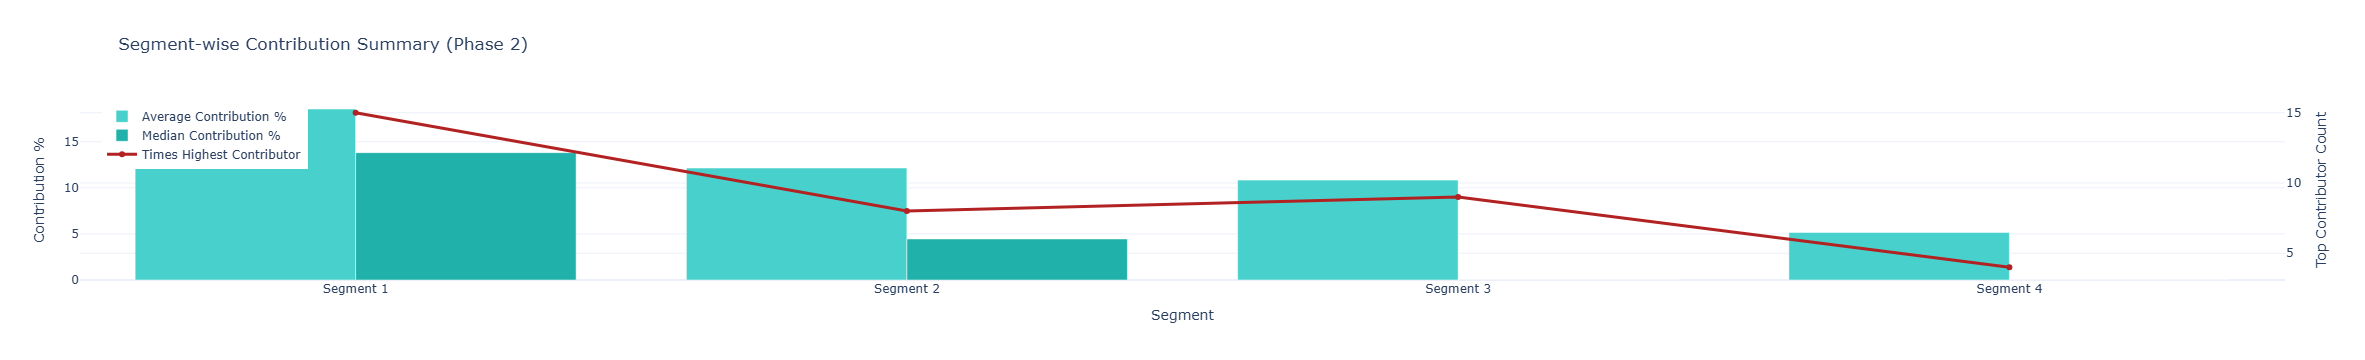

In [6]:
import pandas as pd
import plotly.graph_objects as go

# Load data
df = pd.read_csv("Phase_Segment_Correlation_Stats.csv")

# Filter Phase 2 segments only
segment_df = df[(df["Phase"] == "Phase 2") & (df["Segment"] != "-")]

# Summary: mean and median contribution %
segment_summary = segment_df.groupby("Segment")["Contribution %"].agg(["mean", "median"]).reset_index()
segment_summary.columns = ["Segment", "Average Contribution %", "Median Contribution %"]

# Count top contributor frequency
top_segment_per_coil = (
    segment_df.loc[segment_df.groupby("Coil ID")["Contribution %"].idxmax()]
    .groupby("Segment")["Coil ID"]
    .count()
    .reset_index()
    .rename(columns={"Coil ID": "Times Highest Contributor"})
)

# Merge all metrics
segment_rank_summary = pd.merge(segment_summary, top_segment_per_coil, on="Segment")
segment_rank_summary = segment_rank_summary.sort_values(by="Average Contribution %", ascending=False)

# Plotting
fig = go.Figure()

# Average Contribution
fig.add_trace(go.Bar(
    x=segment_rank_summary["Segment"],
    y=segment_rank_summary["Average Contribution %"],
    name="Average Contribution %",
    marker_color='mediumturquoise'
))

# Median Contribution
fig.add_trace(go.Bar(
    x=segment_rank_summary["Segment"],
    y=segment_rank_summary["Median Contribution %"],
    name="Median Contribution %",
    marker_color='lightseagreen'
))

# Times Highest Contributor (as line overlaid)
fig.add_trace(go.Scatter(
    x=segment_rank_summary["Segment"],
    y=segment_rank_summary["Times Highest Contributor"],
    name="Times Highest Contributor",
    mode="lines+markers",
    line=dict(color="firebrick", width=3),
    yaxis="y2"
))

# Layout
fig.update_layout(
    title="Segment-wise Contribution Summary (Phase 2)",
    xaxis_title="Segment",
    yaxis=dict(title="Contribution %"),
    yaxis2=dict(
        title="Top Contributor Count",
        overlaying="y",
        side="right"
    ),
    barmode='group',
    template='plotly_white',
    legend=dict(x=0.01, y=0.99)
)

fig.show()
